In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import numpy as np
from TableDetect import TableDetect
from MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import torch

/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: U

In [3]:

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

  
def plot_results(model, pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
        cl = p.argmax().item()
        score = p[cl]
        text = f'{model.config.id2label[cl]}: {score:0.2f}'
        
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
        
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    # img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)


def plot_annotations(anns):
    plt.figure(figsize=(10,10))
    background=np.ones_like(sam.image)*255
    plt.imshow(background)
    show_anns(anns)
    plt.axis('off')
    plt.show() 
    # plt.savefig("{}".format("./out/result.jpg"), bbox_inches='tight', pad_inches = 0.0)         


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [4]:
# file_path = "./app/assets/picture1.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"
img = Image.open(file_path)

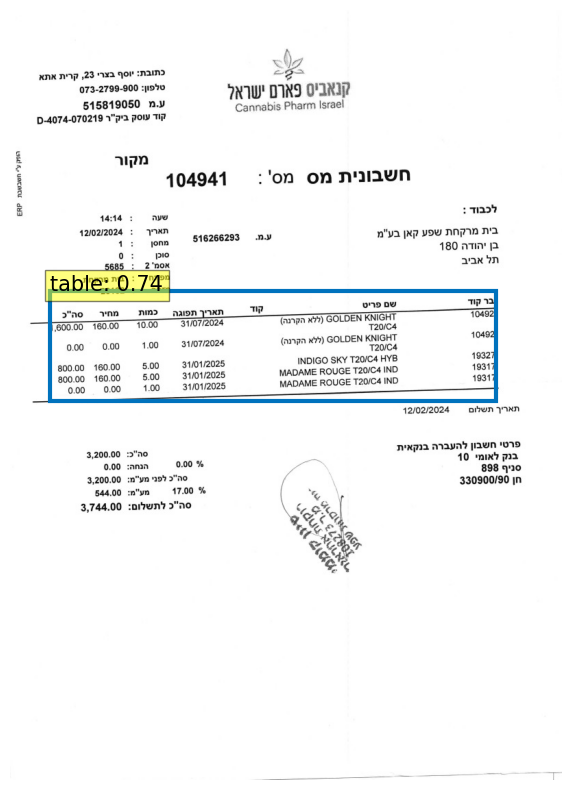

In [5]:
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)
plot_results(tblDec.model, img, probas, boxes)


# Crop table with sam

In [6]:
sam = MobileSamBoxes(img)
anns = sam.process(boxes)

checkpoint_load_scucess
shape (1124, 805, 3)
------ total time: (s): 1.8


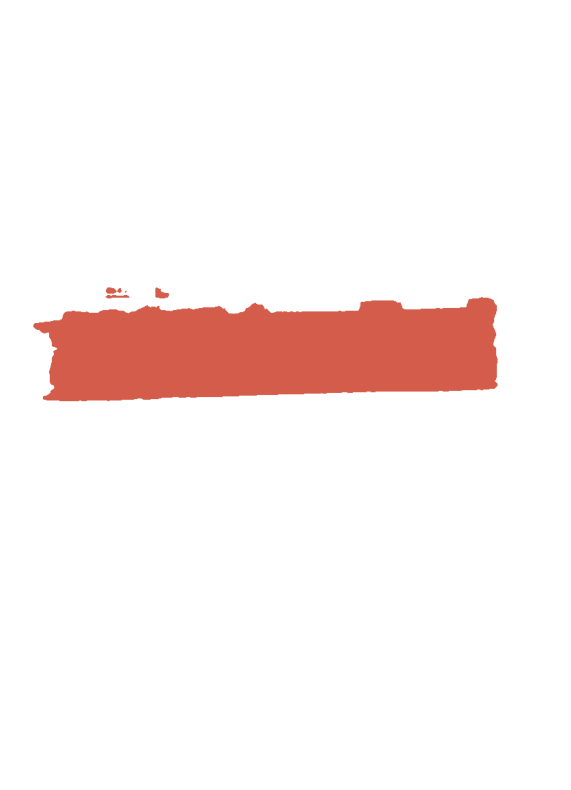

In [7]:
plot_annotations(anns)



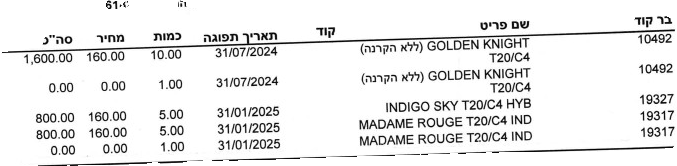

In [200]:
from PIL import Image
import cv2

def create_mask_patch(image, mask):
  """
  Creates a patch from the image containing only the mask region.

  Args:
      image: A PIL image object.
      mask: A NumPy array representing the mask (1 for mask pixels).

  Returns:
      A PIL image object containing the patch from the original image 
      with only the mask region and white background for non-mask pixels.
  """
  mask=mask.cpu().numpy()
  # mask = cv2.dilate(mask, np.ones((13, 13), np.uint8), iterations=1)  
  # Find non-zero elements (mask pixels) in the mask
  mask_coords = np.where(mask != 0)

  # Get minimum and maximum coordinates from the mask pixels
  min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
  max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

  # Create the bounding box rectangle
  bounding_box = (min_x, min_y, max_x, max_y)


  mask = mask==1
  imgArr = np.array(image)
  imgArr[~mask] = (255,255,255)
  image = Image.fromarray(imgArr)
  # color_mask = np.concatenate([np.random.random(3), [1]])
  # img[m] = color_mask
  # Crop the image using the bounding box
  patch_image = image.crop(bounding_box)
  return patch_image

# Example usage
mask = anns[0]

tbl_patch = create_mask_patch(img, mask)
# patch.show()  # Display the created patch
tbl_patch


# Table structure recognition

In [201]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(tbl_patch, return_tensors="pt")
encoding.keys()

/Users/eliaweiss/opt/anaconda3/envs/mobileSam/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [202]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [203]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
""

''

In [204]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [205]:
pixel_values = structure_transform(tbl_patch).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 245, 1000])


In [206]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [207]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, tbl_patch.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9985131621360779, 'bbox': [78.83982849121094, 13.113717079162598, 136.78070068359375, 155.01644897460938]}, {'label': 'table spanning cell', 'score': 0.5591042041778564, 'bbox': [22.99848175048828, 13.150827407836914, 78.75277709960938, 50.98837661743164]}, {'label': 'table column', 'score': 0.9984728693962097, 'bbox': [344.58758544921875, 13.051971435546875, 583.32177734375, 154.93161010742188]}, {'label': 'table row', 'score': 0.9764707088470459, 'bbox': [22.837913513183594, 32.45429229736328, 674.8787841796875, 64.96265411376953]}, {'label': 'table column', 'score': 0.9996190071105957, 'bbox': [584.0509033203125, 13.1600923538208, 674.8800659179688, 155.13726806640625]}, {'label': 'table column header', 'score': 0.9024192690849304, 'bbox': [22.920515060424805, 13.264165878295898, 674.5650634765625, 32.84412384033203]}, {'label': 'table row', 'score': 0.9963462948799133, 'bbox': [22.755434036254883, 65.70690155029297, 674.7307739257812, 96.217742

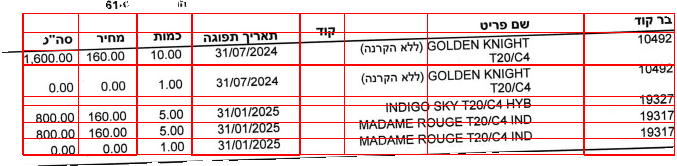

In [208]:
from PIL import ImageDraw

cropped_table_visualized = tbl_patch.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [209]:
def plot_results_cells(tbl_patch, cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError(f"Class should be one of the available classes {structure_model.config.id2label}")

    plt.figure(figsize=(16,10))
    plt.imshow(tbl_patch)
    ax = plt.gca()

    for cell in cells:
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=np.random.random(3), linewidth=3))
          plt.axis('off')

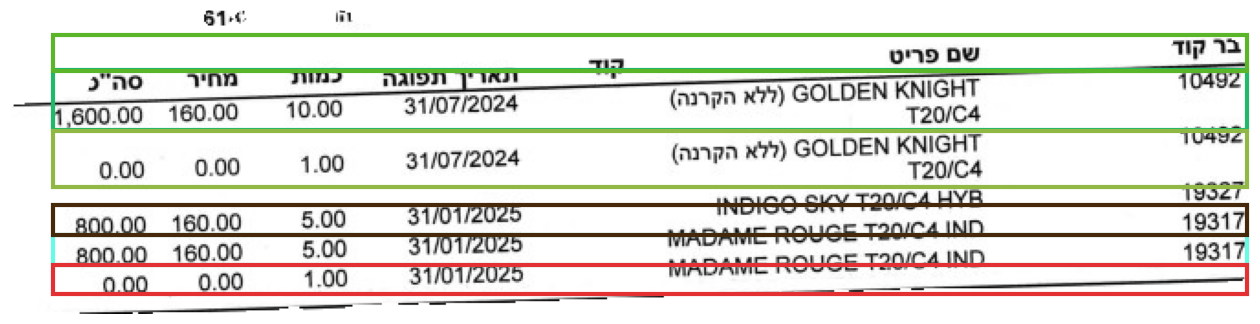

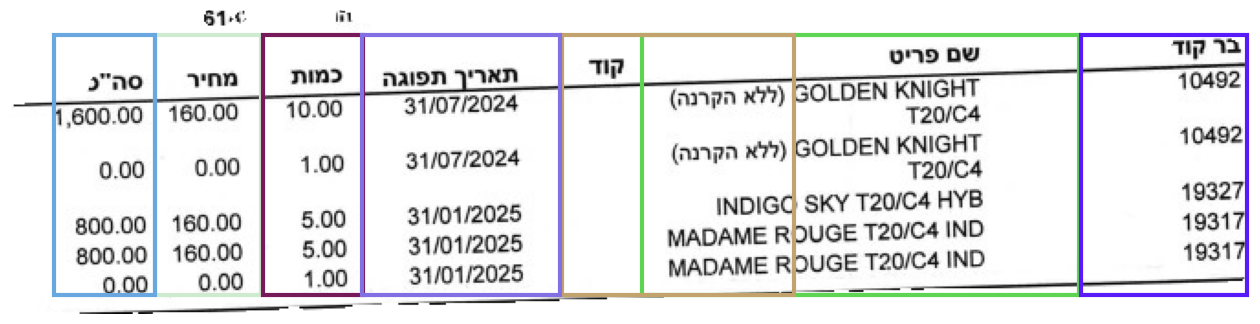

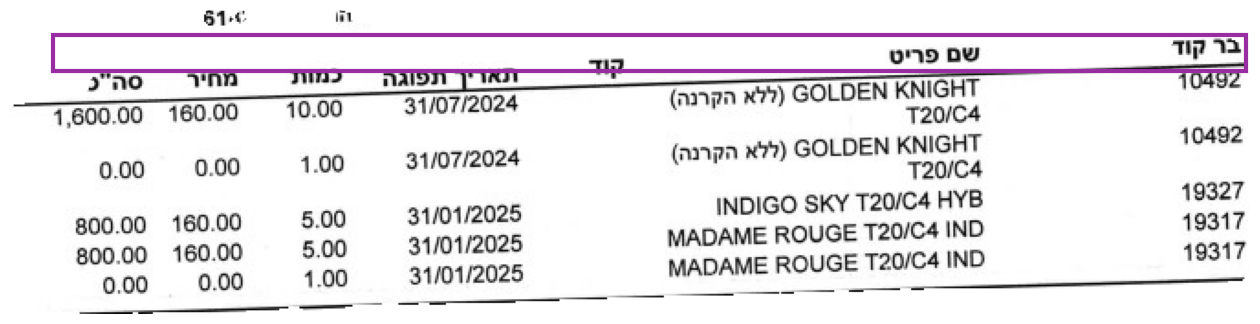

In [210]:
plot_results_cells(tbl_patch,cells, class_to_visualize="table row")
plot_results_cells(tbl_patch, cells, class_to_visualize="table column")
plot_results_cells(tbl_patch,cells, class_to_visualize="table column header")
# plot_results_cells(tbl_patch,cells, class_to_visualize="table projected row header")
# plot_results_cells(tbl_patch,cells, class_to_visualize="table spanning cell")

# align table

In [211]:
m = anns[0].bool()
m=m.cpu().numpy()
mask = np.zeros((anns.shape[1], anns.shape[2], 1), np.uint8)
mask[m] = 255
# mask = ~mask
print(mask.shape)
print(mask.dtype)

(1124, 805, 1)
uint8


In [212]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]
len(contours)

5

In [213]:
image = np.array(img)

In [214]:
def calcBB():
    mask_coords = np.where(mask != 0)

# Get minimum and maximum coordinates from the mask pixels
    min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
    max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

# Define the dimensions of the output rectangle
    width = max_x-min_x  # Define your desired width here
    height = max_y-min_y  # Define your desired height here
    return (min_x, max_x), (min_y, max_y), (width,height)



In [215]:
def linear_interpolation_midpoint(p1,p2):
  (x1, y1) = p1
  (x2, y2) = p2
  # Calculate the slopes in x and y directions
  slope_x = (x2 - x1) / 2
  slope_y = (y2 - y1) / 2

  # Calculate the midpoint coordinates
  midpoint_x = x1 + slope_x
  midpoint_y = y1 + slope_y

  return midpoint_x, midpoint_y

In [216]:


import cv2
import numpy as np

def find_closest_point_in_contour(contour, point_xy):
   """
   Finds the closest point within a contour to a given point.

   Args:
       contour: A NumPy array representing the contour, where each row is a (x, y) point.
       point_xy: A tuple of (x, y) coordinates for the reference point.

   Returns:
       A tuple representing the (x, y) coordinates of the closest point in the contour.
   """

   min_dist = np.inf
   closest_point = None

   for contour_point in contour:
       x, y = contour_point[0]
       dist = np.sqrt((x - point_xy[0])**2 + (y - point_xy[1])**2)
       if dist < min_dist:
           min_dist = dist
           closest_point = x, y

   return closest_point
#    return linear_interpolation_midpoint(closest_point,point_xy)

def approxBoundingQuadrilateral(find_closest_point_in_contour):
    (min_x, max_x), (min_y, max_y), (width,height) = calcBB()
    lb = find_closest_point_in_contour(contour, (min_x,min_y))
    lt = find_closest_point_in_contour(contour, (min_x,max_y))
    rt = find_closest_point_in_contour(contour, (max_x,max_y))
    rb = find_closest_point_in_contour(contour, (max_x,min_y))
    # return clock wise
    return (lb,rb, rt, lt), (width,height)

boundingQuadrilateral, (width,height) = approxBoundingQuadrilateral(find_closest_point_in_contour)
boundingQuadrilateral

((42, 456), (702, 422), (706, 552), (48, 567))

In [217]:
lb,rb,_,_ = boundingQuadrilateral
mask_coords = np.array( [lb,rb])
mask_coords


array([[ 42, 456],
       [702, 422]], dtype=int32)

In [218]:
mask_coords = mask_coords.T

In [219]:
mask_coords

array([[ 42, 702],
       [456, 422]], dtype=int32)

In [220]:
print(mask_coords[0].min())
print(mask_coords[0].max())

42
702


In [221]:
print(mask_coords[1].min())
print(mask_coords[1].max())

422
456


In [222]:
# Get minimum and maximum coordinates from the mask pixels
l, r  = mask_coords[0].min(), mask_coords[0].max()
b, t = mask_coords[1].min()+1, mask_coords[1].max()+1
bbox = [(int(l),int(b)), (int(r), int(t))]
bbox

[(42, 423), (702, 457)]

In [223]:

points = contour.squeeze()
points.shape 

(442, 2)

In [224]:

def find_points_in_bbox(bbox, points):
 """
 Finds all points within a given bounding box.

 Args:
   bbox: A list of two tuples representing the top-left and bottom-right corners of the bounding box.
     Ex: [(left, bottom), (top, right)]
   points: A list of tuples representing the points to check.
     Ex: [(x1, y1), (x2, y2), ...]

 Returns:
   A list of points that are within the bounding box.
 """

 l, b = bbox[0]  # Extract left and bottom coordinates
 r, t = bbox[1]  # Extract top and right coordinates

 points_inside = []
 for x, y in points:
   if l <= x <= r and b <= y <= t:  # Check if point is within bbox boundaries
     points_inside.append((x, y))

 return points_inside

points_inside = find_points_in_bbox(bbox, points)
len(points_inside)

220

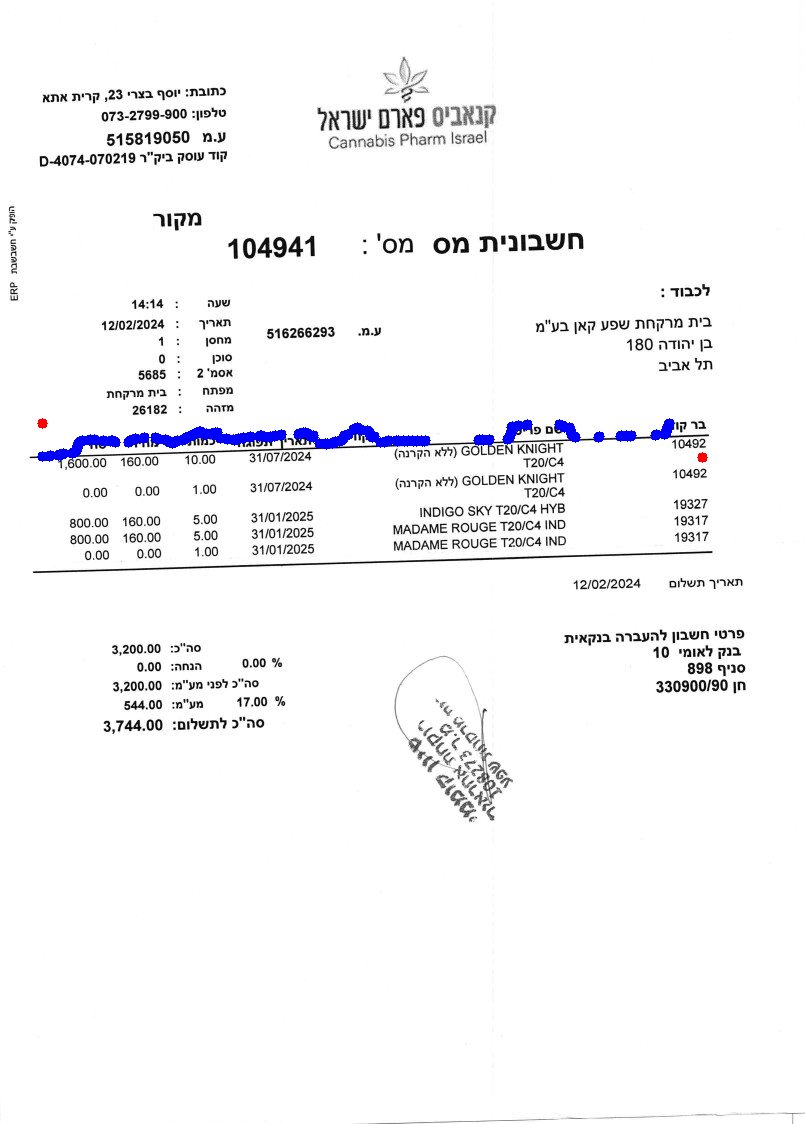

In [225]:
tmpImg = image.copy()
# Iterate through points and draw them on the image
for point in points_inside:
    cv2.circle(tmpImg, point, radius=5, color=(0, 0, 255), thickness=-1)  # Red circles
cv2.circle(tmpImg, bbox[0], radius=5, color=(255,0, 0), thickness=-1)  # Red circles
cv2.circle(tmpImg, bbox[1], radius=5, color=(255,0, 0), thickness=-1)  # Red circles

Image.fromarray(tmpImg)

In [226]:

def find_approximate_line(points_inside):
    """
    Finds the approximate line using linear regression for a given set of points.

    Args:
        points_inside: A list of tuples representing the points to fit the line to.

    Returns:
        A tuple containing the slope and intercept of the estimated line.
    """

    x_vals = [point[0] for point in points_inside]
    y_vals = [point[1] for point in points_inside]

    # Use numpy's polyfit function for linear regression
    slope, intercept = np.polyfit(x_vals, y_vals, 1)

    return slope, intercept

slope, intercept = find_approximate_line(points_inside)

print("Approximate line: y = {}x + {}".format(slope, intercept))

Approximate line: y = -0.02081461362052286x + 443.6333205993599


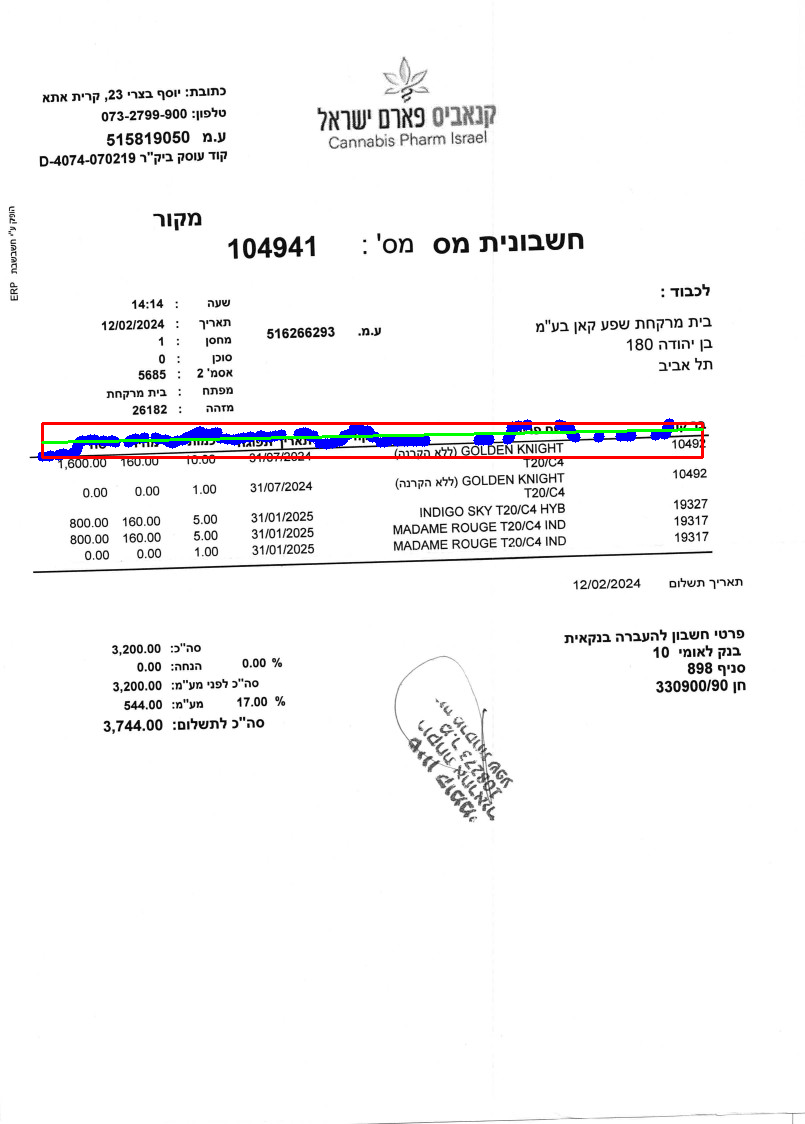

In [227]:

def draw_line_on_image(img, points_inside, bbox):
  """
  Draws the approximate line and bounding box on the image.

  Args:
      img: The image as a NumPy array.
      points_inside: A list of tuples representing points inside the bounding box.
      bbox: A list of two tuples representing the top-left and bottom-right corners of the bounding box.
  """

  # Find approximate line
  slope, intercept = find_approximate_line(points_inside)

  # Calculate line endpoints for visualization (assuming image width is in img.shape[1])
  x1 = bbox[0][0]  # Left edge of bounding box
  y1 = int(slope * x1 + intercept)  # Calculate y-coordinate for x1 using the line equation
  x2 = bbox[1][0]  # Right edge of bounding box
  y2 = int(slope * x2 + intercept)  # Calculate y-coordinate for x2 using the line equation

  # Draw points
  for point in points_inside:
      cv2.circle(img, point, radius=5, color=(0, 0, 255), thickness=-1)  # Red circles

  # Draw bounding box
  cv2.rectangle(img, bbox[0], bbox[1], color=(255, 0, 0), thickness=2)  # Blue rectangle

  # Draw line
  cv2.line(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)  # Green line

tmpImg = image.copy()
# Draw line and bounding box on the image
draw_line_on_image(tmpImg, points_inside, bbox)

Image.fromarray(tmpImg)

In [228]:
def calculate_angle(slope):
    """
    Calculates the angle of the line relative to the x-axis in degrees.

    Args:
    slope: The slope of the estimated line.

    Returns:
    The angle of the line in degrees.
    """

    # Use arctangent (atan) to find the angle in radians
    radians = np.arctan(slope)

    # Convert radians to degrees
    angle_in_degrees = np.rad2deg(radians)

    return angle_in_degrees
angle = calculate_angle(slope)
angle

-1.192417328345599

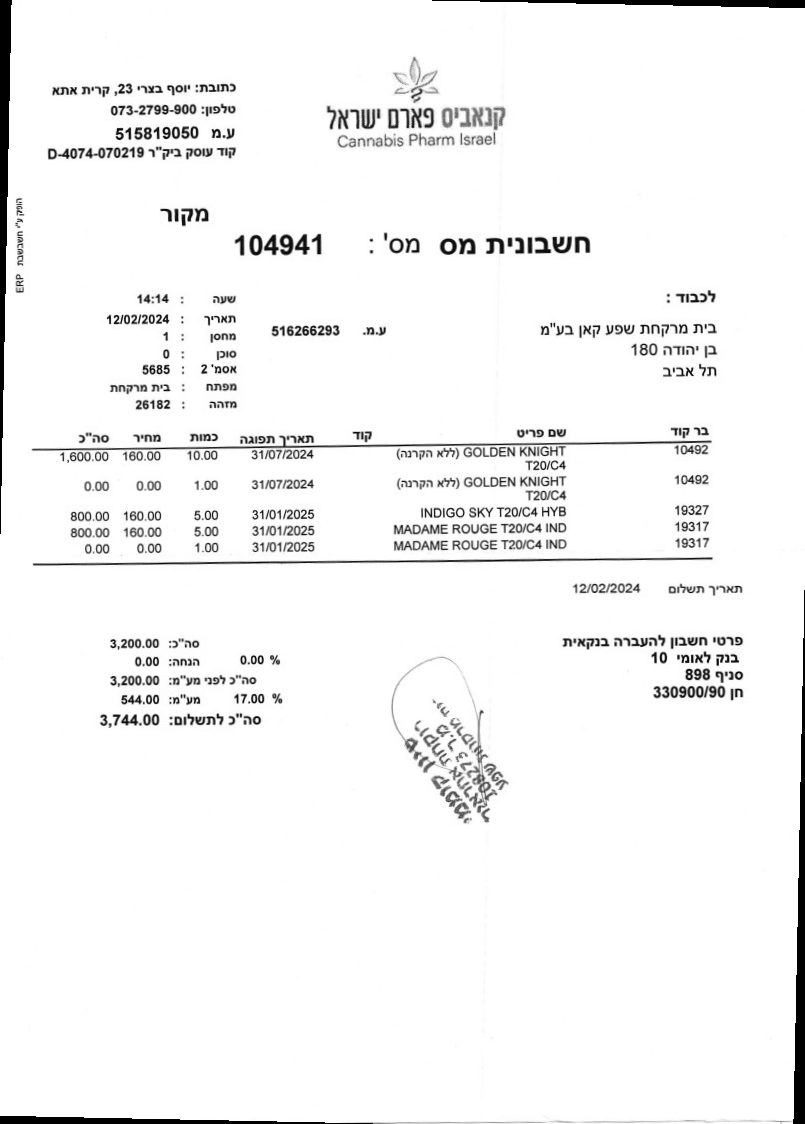

In [229]:
# tmpImg2 = Image.fromarray(tmpImg)
tmpImg2 = Image.fromarray(image.copy())
tmpImg2 =  tmpImg2.rotate(angle, resample=Image.BILINEAR)
tmpImg2

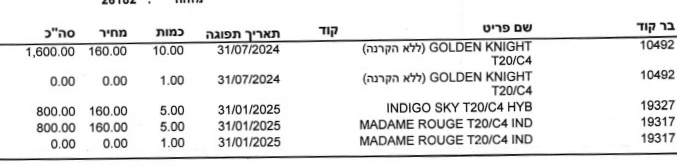

In [230]:
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()

alignTable = tmpImg2.crop([min_x, min_y,max_x, max_y])
alignTable

# Find cell from align tbl

In [231]:
pixel_values = structure_transform(alignTable).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 245, 1000])


In [232]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [233]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, alignTable.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9991462230682373, 'bbox': [80.34052276611328, 18.32567596435547, 138.7504119873047, 149.0287322998047]}, {'label': 'table column', 'score': 0.9995050430297852, 'bbox': [339.92132568359375, 18.49114418029785, 584.6082763671875, 148.6999053955078]}, {'label': 'table row', 'score': 0.981952965259552, 'bbox': [24.193832397460938, 36.0988655090332, 674.3765869140625, 71.4271240234375]}, {'label': 'table column', 'score': 0.9997507929801941, 'bbox': [585.7030639648438, 18.528451919555664, 674.460693359375, 148.90093994140625]}, {'label': 'table column header', 'score': 0.9933508038520813, 'bbox': [24.086959838867188, 18.633485794067383, 674.2327880859375, 36.18071365356445]}, {'label': 'table row', 'score': 0.9902058243751526, 'bbox': [24.048826217651367, 68.54277801513672, 674.2090454101562, 100.63380432128906]}, {'label': 'table row', 'score': 0.9989551305770874, 'bbox': [24.245342254638672, 116.35734558105469, 674.22314453125, 132.68687438964844]}, {'

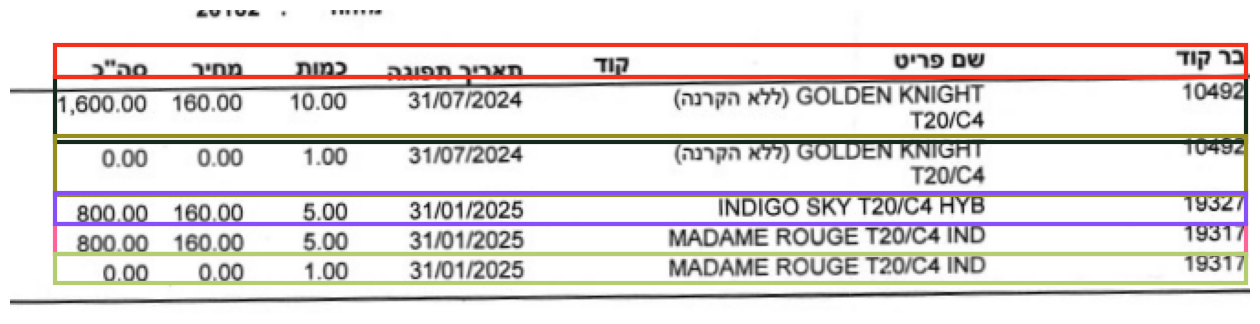

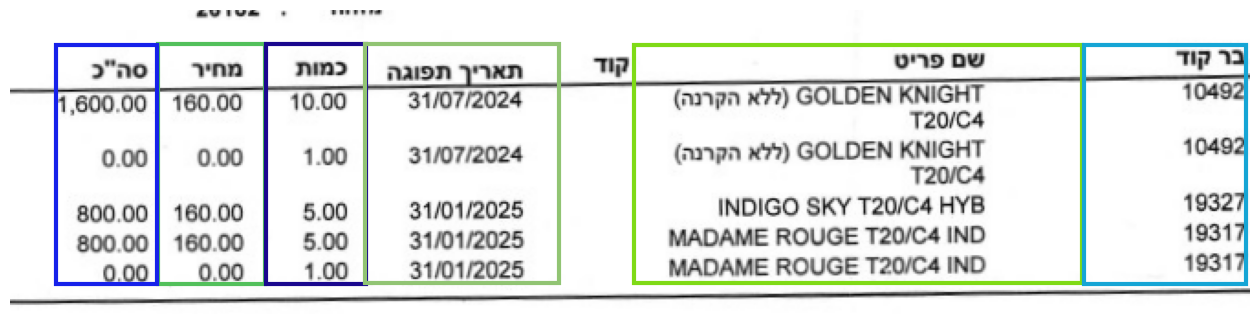

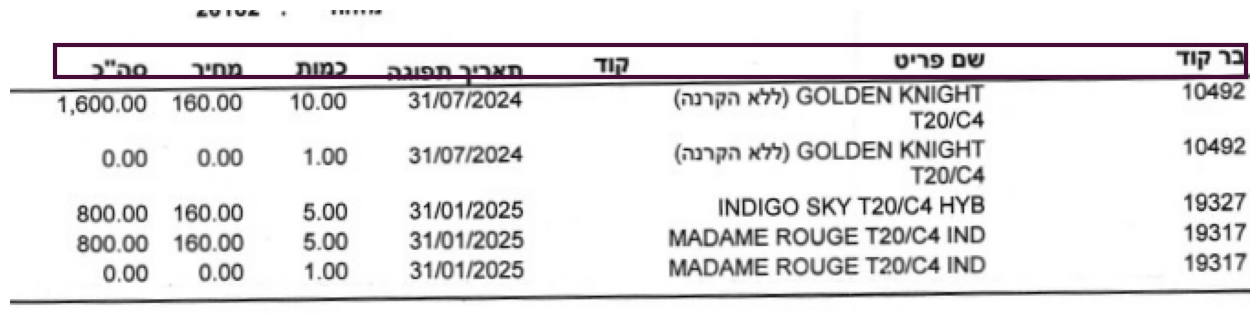

In [234]:
plot_results_cells(alignTable,cells, class_to_visualize="table row")
plot_results_cells(alignTable, cells, class_to_visualize="table column")
plot_results_cells(alignTable,cells, class_to_visualize="table column header")

# Find the inverse homography matrix